## Imports

In [14]:
import os
import argparse
import random
import math
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from scipy.ndimage import gaussian_filter
from dataset.medical_zero import MedTestDataset, MedTrainDataset
from CLIP.clip import create_model
from CLIP.tokenizer import tokenize
from CLIP.adapter import CLIP_Inplanted
from PIL import Image
from sklearn.metrics import precision_recall_curve
from loss import FocalLoss, BinaryDiceLoss
from utils import augment, encode_text_with_prompt_ensemble
from prompt import REAL_NAME

import warnings
warnings.filterwarnings("ignore")

In [15]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

CLASS_INDEX = {'Brain':3, 'Liver':2, 'Retina_RESC':1, 'Retina_OCT2017':-1, 'Chest':-2, 'Histopathology':-3}
CLASS_INDEX_INV = {3:'Brain', 2:'Liver', 1:'Retina_RESC', -1:'Retina_OCT2017', -2:'Chest', -3:'Histopathology'}

In [16]:
args = {
    'model_name': 'ViT-L-14-336',
    'pretrain': 'openai',
    'obj': 'Liver',
    'data_path': './data/',
    'batch_size': 1,
    'img_size': 240,
    'save_path': './ckpt/zero-shot/',
    'epoch': 50,
    'learning_rate': 0.0001,
    'features_list': [6, 12, 18, 24],
    'seed': 111
}

In [17]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
setup_seed(args['seed'])

In [18]:
clip_model = create_model(model_name=args['model_name'], 
                          img_size=args['img_size'], 
                          device=device, 
                          pretrained=args['pretrain'], 
                          require_pretrained=True)
clip_model.eval()

model = CLIP_Inplanted(clip_model=clip_model, features=args['features_list']).to(device)
model.eval()

checkpoint = torch.load(os.path.join(f'{args["save_path"]}', f'{args["obj"]}.pth'))
model.seg_adapters.load_state_dict(checkpoint["seg_adapters"])
model.det_adapters.load_state_dict(checkpoint["det_adapters"])

<All keys matched successfully>

In [26]:
for name, param in model.named_parameters():
    param.requires_grad = True

In [20]:
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

In [21]:
test_dataset = MedTestDataset(args['data_path'], args['obj'], args['img_size'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, **kwargs)

In [22]:
text_feature_list = [0]
# text prompt
with torch.cuda.amp.autocast(), torch.no_grad():
    for i in [1,2,3,-3,-2,-1]:
        text_feature = encode_text_with_prompt_ensemble(clip_model, REAL_NAME[CLASS_INDEX_INV[i]], device)
        text_feature_list.append(text_feature)
    
text_features = text_feature_list[CLASS_INDEX[args['obj']]]

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
text_features

In [ ]:
gt_list = []
gt_mask_list = []
image_scores = []
segment_scores = []
image_list = []
copy_ori_seg_patch_tokens  = None
for (image, y, mask) in tqdm(test_loader):
    image = image.to(device)
    mask[mask > 0.5], mask[mask <= 0.5] = 1, 0

    with torch.no_grad(), torch.cuda.amp.autocast():
        _, ori_seg_patch_tokens, ori_det_patch_tokens = model(image)
        ori_seg_patch_tokens = [p[0, 1:, :] for p in ori_seg_patch_tokens]
        ori_det_patch_tokens = [p[0, 1:, :] for p in ori_det_patch_tokens]
        copy_ori_seg_patch_tokens = ori_seg_patch_tokens
        # image
        anomaly_score = 0
        patch_tokens = ori_det_patch_tokens.copy()
        for layer in range(len(patch_tokens)):
            print(patch_tokens[layer])
            patch_tokens[layer] /= patch_tokens[layer].norm(dim=-1, keepdim=True)
            anomaly_map = (100.0 * patch_tokens[layer] @ text_features).unsqueeze(0)
            anomaly_map = torch.softmax(anomaly_map, dim=-1)[:, :, 1]
            anomaly_score += anomaly_map.mean()
        image_scores.append(anomaly_score.cpu())

        # pixel
        patch_tokens = ori_seg_patch_tokens
        anomaly_maps = []
        for layer in range(len(patch_tokens)):
            patch_tokens[layer] /= patch_tokens[layer].norm(dim=-1, keepdim=True)
            anomaly_map = (100.0 * patch_tokens[layer] @ text_features).unsqueeze(0)
            B, L, C = anomaly_map.shape
            H = int(np.sqrt(L))
            anomaly_map = F.interpolate(anomaly_map.permute(0, 2, 1).view(B, 2, H, H),
                                        size=args['img_size'], mode='bilinear', align_corners=True)
            anomaly_map = torch.softmax(anomaly_map, dim=1)[:, 1, :, :]
            anomaly_maps.append(anomaly_map.cpu().numpy())
        final_score_map = np.sum(anomaly_maps, axis=0)
        
        gt_mask_list.append(mask.squeeze().cpu().detach().numpy())
        image_list.append(image.squeeze().cpu().detach().numpy())
        gt_list.extend(y.cpu().detach().numpy())
        segment_scores.append(final_score_map)

In [ ]:
segment_scores[0].shape

In [ ]:
gt_list = np.array(gt_list)
gt_mask_list = np.asarray(gt_mask_list)
gt_mask_list = (gt_mask_list>0).astype(np.int_)

segment_scores = np.array(segment_scores)
image_scores = np.array(image_scores)

segment_scores = (segment_scores - segment_scores.min()) / (segment_scores.max() - segment_scores.min())
image_scores = (image_scores - image_scores.min()) / (image_scores.max() - image_scores.min())

In [23]:
img_roc_auc_det = roc_auc_score(gt_list, image_scores)
print(f'{args["obj"]} AUC : {round(img_roc_auc_det,4)}')

if CLASS_INDEX[args["obj"]] > 0:
    seg_roc_auc = roc_auc_score(gt_mask_list.flatten(), segment_scores.flatten())
    print(f'{args["obj"]} pAUC : {round(seg_roc_auc,4)}')

NameError: name 'gt_list' is not defined

In [24]:
from torchvision import transforms

transform_image = transforms.Compose([
        transforms.Resize((args['img_size'], args['img_size']), Image.BICUBIC),
        transforms.ToTensor(),
    ])

transform_mask = transforms.Compose(
            [transforms.Resize((args['img_size'], args['img_size']), Image.NEAREST),
             transforms.ToTensor()])

In [25]:
loss_focal = FocalLoss()
loss_dice = BinaryDiceLoss()
loss_bce = torch.nn.BCEWithLogitsLoss()

In [23]:
import cv2
def generate_grad_cam(model, ori_image, image_label, ori_mask):
    """
    :param model: deep learning network(ResNet DataParallel object)
    :param ori_image: the original image
    :return: gradient class activation map
    """
    input_image = transform_image(ori_image)
    input_image = input_image.unsqueeze(0)
    input_image = input_image.to(device)
    
    mask = transform_mask(ori_mask)
    mask = mask.unsqueeze(0)
    mask = mask.to(device)
    
    feature = None
    gradient = None

    def func_f(module, input, output):
        nonlocal feature
        feature = output.data.cpu().numpy()

    def func_b(module, grad_in, grad_out):
        nonlocal gradient
        gradient = grad_out[0].data.cpu().numpy()

    model.seg_adapters[3].fc1.register_forward_hook(func_f)
    model.seg_adapters[3].fc1.register_backward_hook(func_b)

    with torch.cuda.amp.autocast():
        _, seg_patch_tokens, det_patch_tokens = model(input_image)
        seg_patch_tokens = [p[0, 1:, :] for p in seg_patch_tokens]
        det_patch_tokens = [p[0, 1:, :] for p in det_patch_tokens]
        
        # image level
        det_loss = 0
        image_label = image_label.to(device)
        for layer in range(len(det_patch_tokens)):
            det_patch_tokens[layer] = det_patch_tokens[layer] / det_patch_tokens[layer].norm(dim=-1, keepdim=True)
            anomaly_map = (100.0 * det_patch_tokens[layer] @ text_features).unsqueeze(0)    
            anomaly_map = torch.softmax(anomaly_map, dim=-1)[:, :, 1]
            anomaly_score = torch.mean(anomaly_map, dim=-1)
            det_loss += loss_bce(anomaly_score, image_label)
            
        if CLASS_INDEX[args['obj']] > 0:
            # pixel level
            seg_loss = 0
            mask = mask.to(device)
            mask[mask > 0.5], mask[mask <= 0.5] = 1, 0
            for layer in range(len(seg_patch_tokens)):
                seg_patch_tokens[layer] = seg_patch_tokens[layer] / seg_patch_tokens[layer].norm(dim=-1, keepdim=True)
                # print(seg_patch_tokens[layer].shape, text_feature_list[seg_idx].shape) # torch.Size([289, 768]) torch.Size([768, 2])
                anomaly_map = (100.0 * seg_patch_tokens[layer] @ text_features).unsqueeze(0)
                B, L, C = anomaly_map.shape
                H = int(np.sqrt(L))
                anomaly_map = F.interpolate(anomaly_map.permute(0, 2, 1).view(B, 2, H, H),
                                            size=args['img_size'], mode='bilinear', align_corners=True)
                anomaly_map = torch.softmax(anomaly_map, dim=1)
                # return anomaly_map, mask
                seg_loss += loss_focal(anomaly_map, mask)
                seg_loss += loss_dice(anomaly_map[:, 1, :, :], mask)
                
            loss = seg_loss + det_loss # = focal(seg_out, mask) + bce(det_out, y)
            loss.requires_grad_(True)
            model.zero_grad()
            loss.backward()
            
        else:
            loss = det_loss
            loss.requires_grad_(True)
            model.zero_grad()
            loss.backward()

    return feature, gradient
    feature = np.squeeze(feature, axis=0)
    gradient = np.squeeze(gradient, axis=0)

    weights = np.mean(gradient, axis=(1, 2), keepdims=True)

    cam = np.sum(weights * feature, axis=0)

    cam = cv2.resize(cam, (args['img_size'], args['img_size']))
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
    cam = 1.0 - cam
    cam = np.uint8(cam * 255)

    return feature, gradient, cam

In [24]:
img_path = "./data/Brain_AD/test/Ungood/img/00002_60.png"
mask_path = "./data/Brain_AD/test/Ungood/anomaly_mask/00002_60.png"

In [39]:
ori_image = Image.open(img_path).convert('RGB')
image_label = torch.Tensor([0])
mask = Image.open(img_path).convert('L')
feature, gradient = generate_grad_cam(model, ori_image, image_label, mask)

In [40]:
feature = np.squeeze(feature, axis=1)
gradient = np.squeeze(gradient, axis=1)

feature = np.expand_dims(feature, axis=0)
gradient = np.expand_dims(gradient, axis=0)


In [41]:
gradient.shape

(1, 290, 768)

In [42]:
weights = np.mean(gradient, axis=(1, 2), keepdims=True)
weights

array([[[-3.34e-06]]], dtype=float16)

In [43]:
cam = np.sum(weights * feature, axis=0)
cam = cv2.resize(cam, (args['img_size'], args['img_size']))
cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
cam = 1.0 - cam
cam = np.uint8(cam * 255)

error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4030: error: (-215:Assertion failed) func != 0 in function 'resize'


In [49]:
test = torch.tensor(cam)
test = test.unsqueeze(0)

In [50]:
test.shape

torch.Size([1, 290, 768])

In [51]:
F.interpolate(test.permute(0, 2, 1).view(B, 2, H, H),
                                        size=args['img_size'], mode='bilinear', align_corners=True)

RuntimeError: shape '[1, 2, 17, 17]' is invalid for input of size 222720

In [43]:
seg_patch_tokens_cpu = seg_patch_tokens[3].permute(1, 0, 2).cpu().detach().numpy()
seg_patch_tokens_cpu.shape

(290, 1, 768)

In [42]:
det_patch_tokens[0] @ text_features

tensor([[-1.0059, -0.4556],
        [-0.9482, -0.4756],
        [-0.9258, -0.4929],
        [-0.8828, -0.4204],
        [-0.7793, -0.3315],
        [-0.9907, -0.4956],
        [-0.7295, -0.2737],
        [-0.7793, -0.2817],
        [-0.8481, -0.3767],
        [-0.9443, -0.4219],
        [-0.8799, -0.3235],
        [-1.0449, -0.4861],
        [-0.7715, -0.2673],
        [-0.7695, -0.2744],
        [-0.9487, -0.4805],
        [-1.0479, -0.5391],
        [-1.0430, -0.4680],
        [-1.0254, -0.4944],
        [-0.9902, -0.5415],
        [-0.9424, -0.5361],
        [-0.8311, -0.4177],
        [-0.6475, -0.2568],
        [-0.8867, -0.4634],
        [-0.7231, -0.3030],
        [-0.7485, -0.3267],
        [-0.8003, -0.4060],
        [-0.8784, -0.4302],
        [-0.7764, -0.3025],
        [-0.9399, -0.4617],
        [-0.7310, -0.2834],
        [-0.7534, -0.3176],
        [-0.8325, -0.4485],
        [-1.0371, -0.5693],
        [-1.0547, -0.5249],
        [-1.0430, -0.4609],
        [-0.8423, -0

In [33]:
text_features.shape

torch.Size([768, 2])

In [29]:
for layer in range(len(det_patch_tokens)):
    print(det_patch_tokens[layer])
    det_patch_tokens[layer] = det_patch_tokens[layer] / det_patch_tokens[layer].norm(dim=-1, keepdim=True)
    anomaly_map = (100.0 * det_patch_tokens[layer] @ text_features).unsqueeze(0)    
    anomaly_map = torch.softmax(anomaly_map, dim=-1)[:, :, 1]
    anomaly_score = torch.mean(anomaly_map, dim=-1)

tensor([[-2.6877e-04,  5.6491e-02, -3.2578e-04,  ...,  1.0604e-01,
         -7.8517e-05,  9.3299e-02],
        [-2.2735e-04,  6.0554e-02, -3.2805e-04,  ...,  9.8998e-02,
         -2.2143e-04,  8.7347e-02],
        [-4.9577e-04,  5.7541e-02, -4.4060e-04,  ...,  7.5904e-02,
         -2.3508e-04,  8.8344e-02],
        ...,
        [-1.4151e-04,  2.0246e-02,  5.9236e-03,  ...,  6.4285e-02,
         -1.6912e-04,  7.8922e-02],
        [ 4.6403e-03,  2.5585e-02,  1.1323e-02,  ...,  9.4562e-02,
         -1.3634e-04,  8.0913e-02],
        [ 3.7448e-03,  4.3940e-02,  3.3464e-03,  ...,  9.7564e-02,
         -5.2137e-05,  7.7729e-02]], device='cuda:0', grad_fn=<DivBackward0>)


RuntimeError: expected mat1 and mat2 to have the same dtype, but got: float != c10::Half

In [51]:
gradient.shape

AttributeError: 'NoneType' object has no attribute 'shape'

In [134]:
# seg_idx = 0
# for seg in segment_scores:
#     print(seg.shape)
#     seg = seg * 255
#     seg = seg.astype(np.uint8)
#     # image_save = Image.fromarray(seg)
#     image_save = Image.fromarray(seg[0])
#     # image_save = Image.fromarray(np.transpose(seg, (1, 2, 0)))
#     image_save.save("output_sg_" + str(seg_idx) + ".png")
#     seg_idx += 1

(1, 240, 240)
(1, 240, 240)


In [47]:
test_dataset = MedTestDataset(args['data_path'], args['obj'], args['img_size'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, **kwargs)

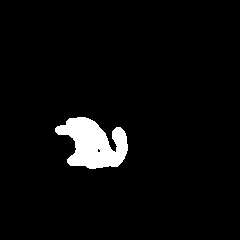

In [110]:
# img_path = "./data/Brain_AD/test/Ungood/anomaly_mask/00002_60.png"
# image = Image.open(img_path).convert('RGB')
# image

mask_path = "./data/Brain_AD/test/Ungood/anomaly_mask/00002_60.png"
mask = Image.open(mask_path).convert('L')
mask

In [111]:
# image_transform = transform_image(image)
# image_transform

mask_transform = transform_mask(mask)
mask_array = np.array(mask_transform)
mask_array[mask_array > 0.5] = 1
mask_array[mask_array <= 0.5] = 0

In [113]:
process_image = mask_array #.squeeze().cpu().detach().numpy()
process_image = process_image * 255
process_image = process_image.astype(np.uint8)
image_save = Image.fromarray(process_image[0])
# image_save = Image.fromarray(np.transpose(process_image, (1, 2, 0)))
image_save.save("./output_img_.png")

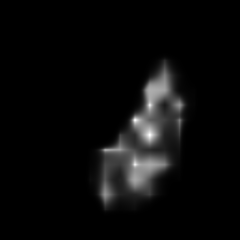

In [137]:
img_path_check = "./output_sg_1.png"
image_check = Image.open(img_path_check)
image_check

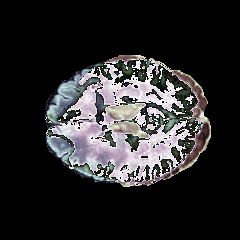

In [82]:
from PIL import Image
import numpy as np

# Load hai hình ảnh
image1 = Image.open("./output_img_0.png")
image2 = Image.open("./output_img_1.png")

# Chuyển đổi hình ảnh sang mảng NumPy
arr1 = np.array(image1)
arr2 = np.array(image2)

# Tính toán sự khác biệt giữa hai hình ảnh
diff_arr = np.abs(arr1 - arr2)

# Chuyển đổi mảng NumPy thành hình ảnh
diff_image = Image.fromarray(diff_arr.astype('uint8'))

# Hiển thị và lưu ảnh kết quả
diff_image.show()
# diff_image.save("difference_image.jpg")

In [36]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import SmoothGradCAMpp
from PIL import Image
import numpy as np

import warnings
warnings.filterwarnings("ignore")


In [40]:

model = resnet18(pretrained=True).eval()
for name, layer in model.named_children():
    print(name, layer)

clipmodel CLIP(
  (visual): VisionTransformer(
    (patchnorm_pre_ln): Identity()
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (patch_dropout): PatchDropout()
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-23): 24 x ResidualAttentionBlock(
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (

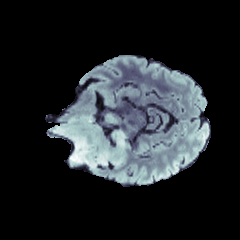

In [128]:
img_path = "./data/Brain_AD/test/Ungood/img/00002_60.png"
image = Image.open(img_path).convert('RGB')
image

In [129]:
image_transform = transform_image(image)
image_transform.shape

torch.Size([3, 240, 240])

In [51]:
from PIL import Image
import numpy as np
import torch
from torchvision.transforms.functional import normalize, resize, to_tensor

# Đọc ảnh và chuyển đổi thành mảng numpy
img_path = "./dog.jpg"
img = Image.open(img_path)
img_array = np.array(img)

# Chuyển đổi mảng numpy thành tensor
img_tensor = to_tensor(img_array)

# Resize và chuẩn hóa
resized_img = resize(img_tensor, (224, 224))  # Sử dụng hàm resize từ torchvision
normalized_img = normalize(resized_img / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [69]:
normalized_img.shape

torch.Size([3, 224, 224])

In [92]:
cam_extractor = SmoothGradCAMpp(model = model, 
                                target_layer = 'seg_adapters.3.fc1',
                                input_shape = (3, 240, 240))
input_model = image_transform.unsqueeze(0)
input_model = input_model.to(device)
out = model(input_model)

handle show layer:

0 ClipAdapter(
  (fc1): Sequential(
    (0): Linear(in_features=1024, out_features=768, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (fc2): Sequential(
    (0): Linear(in_features=768, out_features=1024, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
  )
)
1 ClipAdapter(
  (fc1): Sequential(
    (0): Linear(in_features=1024, out_features=768, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (fc2): Sequential(
    (0): Linear(in_features=768, out_features=1024, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
  )
)
2 ClipAdapter(
  (fc1): Sequential(
    (0): Linear(in_features=1024, out_features=768, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (fc2): Sequential(
    (0): Linear(in_features=768, out_features=1024, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
  )
)
3 ClipAdapter(
  (fc1): Sequential(
    (0): Linear(in_features=1024, out_features=768, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (fc2): Se

In [88]:
handle = out.squeeze().cpu().detach().numpy()

AttributeError: 'tuple' object has no attribute 'squeeze'

AttributeError: 'CLIP_Inplanted' object has no attribute 'seg_adapters.3'

In [113]:
with SmoothGradCAMpp(model = model, 
                    target_layer = 'seg_adapters.3.fc1',
                    input_shape = (3, 240, 240)) as cam_extractor:
    input_model = image_transform.unsqueeze(0)
    input_model = input_model.to(device)
    out = model(input_model)
    cam_extractor(out.squeeze(0).argmax().item(), out)

handle show layer:

0 ClipAdapter(
  (fc1): Sequential(
    (0): Linear(in_features=1024, out_features=768, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (fc2): Sequential(
    (0): Linear(in_features=768, out_features=1024, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
  )
)
1 ClipAdapter(
  (fc1): Sequential(
    (0): Linear(in_features=1024, out_features=768, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (fc2): Sequential(
    (0): Linear(in_features=768, out_features=1024, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
  )
)
2 ClipAdapter(
  (fc1): Sequential(
    (0): Linear(in_features=1024, out_features=768, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (fc2): Sequential(
    (0): Linear(in_features=768, out_features=1024, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
  )
)
3 ClipAdapter(
  (fc1): Sequential(
    (0): Linear(in_features=1024, out_features=768, bias=False)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (fc2): Se

In [114]:
activation_map = cam_extractor(out.argmax().item(), out)

AttributeError: 'tuple' object has no attribute 'argmax'

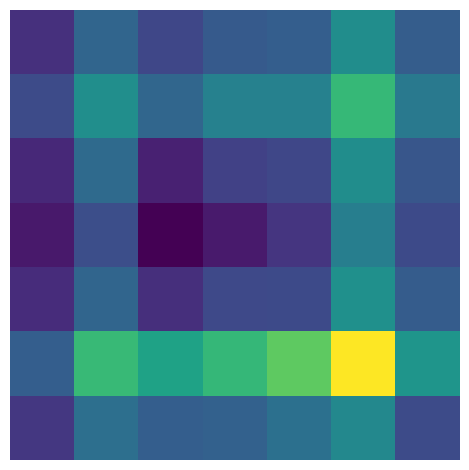

In [23]:
import matplotlib.pyplot as plt
# Visualize the raw CAM
plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

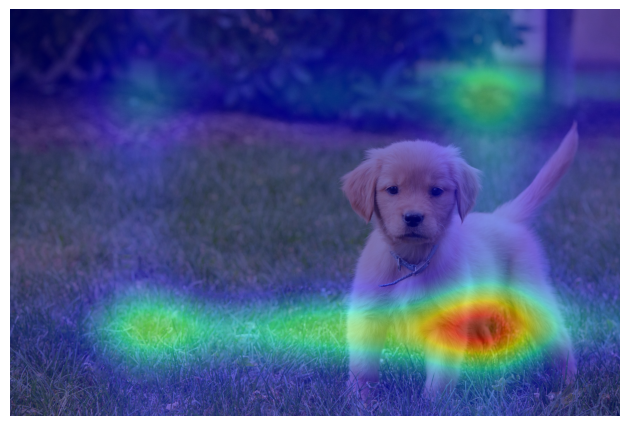

In [25]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

# Resize the CAM and overlay it
result = overlay_mask(img, to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

In [115]:
model_test = resnet18(pretrained=True).eval()
for name, layer in model_test.named_children():
    print(name, layer)

conv1 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
bn1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu ReLU(inplace=True)
maxpool MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
layer1 Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1

In [116]:
from PIL import Image
import numpy as np
import torch
from torchvision.transforms.functional import normalize, resize, to_tensor

# Đọc ảnh và chuyển đổi thành mảng numpy
img_path = "./dog.jpg"
img = Image.open(img_path)
img_array = np.array(img)

# Chuyển đổi mảng numpy thành tensor
img_tensor = to_tensor(img_array)

# Resize và chuẩn hóa
resized_img = resize(img_tensor, (224, 224))  # Sử dụng hàm resize từ torchvision
normalized_img = normalize(resized_img / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [119]:
with SmoothGradCAMpp(model_test) as cam_extractor:
    input_model = normalized_img.unsqueeze(0)
    out = model_test(input_model)

In [121]:
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

torch.Size([1, 1000])

In [123]:
out.squeeze(0).argmax().item()

644

In [125]:
import urllib.request
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
# import clip
from PIL import Image
from scipy.ndimage import filters
from torch import nn

In [126]:
#@title Helper functions

#@markdown Some helper functions for overlaying heatmaps on top
#@markdown of images and visualizing with matplotlib.

def normalize(x: np.ndarray) -> np.ndarray:
    # Normalize to [0, 1].
    x = x - x.min()
    if x.max() > 0:
        x = x / x.max()
    return x

# Modified from: https://github.com/salesforce/ALBEF/blob/main/visualization.ipynb
def getAttMap(img, attn_map, blur=True):
    if blur:
        attn_map = filters.gaussian_filter(attn_map, 0.02*max(img.shape[:2]))
    attn_map = normalize(attn_map)
    cmap = plt.get_cmap('jet')
    attn_map_c = np.delete(cmap(attn_map), 3, 2)
    attn_map = 1*(1-attn_map**0.7).reshape(attn_map.shape + (1,))*img + \
            (attn_map**0.7).reshape(attn_map.shape+(1,)) * attn_map_c
    return attn_map

def viz_attn(img, attn_map, blur=True):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[1].imshow(getAttMap(img, attn_map, blur))
    for ax in axes:
        ax.axis("off")
    plt.show()

def load_image(img_path, resize=None):
    image = Image.open(img_path).convert("RGB")
    if resize is not None:
        image = image.resize((resize, resize))
    return np.asarray(image).astype(np.float32) / 255.

In [127]:
#@title GradCAM: Gradient-weighted Class Activation Mapping

#@markdown Our gradCAM implementation registers a forward hook
#@markdown on the model at the specified layer. This allows us
#@markdown to save the intermediate activations and gradients
#@markdown at that layer.

#@markdown To visualize which parts of the image activate for
#@markdown a given caption, we use the caption as the target
#@markdown label and backprop through the network using the
#@markdown image as the input.
#@markdown In the case of CLIP models with resnet encoders,
#@markdown we save the activation and gradients at the
#@markdown layer before the attention pool, i.e., layer4.

class Hook:
    """Attaches to a module and records its activations and gradients."""

    def __init__(self, module: nn.Module):
        self.data = None
        self.hook = module.register_forward_hook(self.save_grad)

    def save_grad(self, module, input, output):
        self.data = output
        output.requires_grad_(True)
        output.retain_grad()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.hook.remove()

    @property
    def activation(self) -> torch.Tensor:
        return self.data

    @property
    def gradient(self) -> torch.Tensor:
        return self.data.grad


# Reference: https://arxiv.org/abs/1610.02391
def gradCAM(
    model: nn.Module,
    input: torch.Tensor,
    target: torch.Tensor,
    layer: nn.Module
) -> torch.Tensor:
    # Zero out any gradients at the input.
    if input.grad is not None:
        input.grad.data.zero_()

    # Disable gradient settings.
    requires_grad = {}
    for name, param in model.named_parameters():
        requires_grad[name] = param.requires_grad
        param.requires_grad_(False)

    # Attach a hook to the model at the desired layer.
    assert isinstance(layer, nn.Module)
    with Hook(layer) as hook:
        # Do a forward and backward pass.
        output = model(input)
        output.backward(target)

        grad = hook.gradient.float()
        act = hook.activation.float()

        # Global average pool gradient across spatial dimension
        # to obtain importance weights.
        alpha = grad.mean(dim=(2, 3), keepdim=True)
        # Weighted combination of activation maps over channel
        # dimension.
        gradcam = torch.sum(act * alpha, dim=1, keepdim=True)
        # We only want neurons with positive influence so we
        # clamp any negative ones.
        gradcam = torch.clamp(gradcam, min=0)

    # Resize gradcam to input resolution.
    gradcam = F.interpolate(
        gradcam,
        input.shape[2:],
        mode='bicubic',
        align_corners=False)

    # Restore gradient settings.
    for name, param in model.named_parameters():
        param.requires_grad_(requires_grad[name])

    return gradcam

In [ ]:
input_model = image_transform.unsqueeze(0)
input_model = input_model.to(device)
attn_map = gradCAM(
    model,
    input_model,
    model.encode_text(text_input).float(),
    getattr(model.visual, saliency_layer)
)
attn_map = attn_map.squeeze().detach().cpu().numpy()

viz_attn(image_np, attn_map, blur)